# NEURAL NETWORKS FOR TIME SERIES CLASSIFICATION

Welcome to Part 3 of our series about *time series classification*. In this series we want to show how data, e.g. from sensors, can be analyzed using machine learning and AI (Artificial Intelligence) techniques. 

Time series classification is a possible starting point to get an idea how complex applications in practice can be approached using AI. Such applications are for example anomaly detection, remaining useful life estimation, predictive maintenance, etc. 

**What is time series classification?**

Time series can be measurements of signals like temperature, pressure, voltage, etc. These signals can be univariate or multivariate data. Usually, the data consist of of $K$ (e.g. $K=6$) different classes. And here's the key question: 

*Can we find a function that predicts the class for a new, unknown measurement data signal?* 

For a formal definition, the interested reader may be referred to (Fawaz et al. 2019). There are different approaches to get such a function. In this blog we want to focus on the approach known as ***neural networks for classification***. The interested reader may refer to (Fawaz et al. 2019) to get more information about this topic.

Let's import some standard libraries:

In [1]:
import pandas as pd
import numpy as np
from pathlib import Path
import matplotlib.pyplot as plt
import os
import sklearn
import tensorflow as tf
import urllib.request
import zipfile

In C:\ProgramData\Anaconda3\lib\site-packages\matplotlib\mpl-data\stylelib\_classic_test.mplstyle: 
The savefig.frameon rcparam was deprecated in Matplotlib 3.1 and will be removed in 3.3.
In C:\ProgramData\Anaconda3\lib\site-packages\matplotlib\mpl-data\stylelib\_classic_test.mplstyle: 
The verbose.level rcparam was deprecated in Matplotlib 3.1 and will be removed in 3.3.
In C:\ProgramData\Anaconda3\lib\site-packages\matplotlib\mpl-data\stylelib\_classic_test.mplstyle: 
The verbose.fileo rcparam was deprecated in Matplotlib 3.1 and will be removed in 3.3.


In [2]:
print(tf.__version__)
print(tf.keras.__version__)

1.14.0
2.2.4-tf


# 1) The UCI HAR dataset

In literature, there exist many datasets to compare different algorithms. We chose one of these datasets to illustrate the ideas of machine learning and artificial intelligence. 

### Description of the dataset

The UCI HAR dataset is built from the recordings of performing activities while carrying a waist-mounted smartphone with embedded inertial sensors. More info about the signals can be found here: https://archive.ics.uci.edu/ml/datasets/human+activity+recognition+using+smartphones.

Basically, we have $K=6$ activities (= classes):

- 1: WALKING
- 2: WALKING_UPSTAIRS
- 3: WALKING_DOWNSTAIRS
- 4: SITTING
- 5: STANDING
- 6: LAYING.

For each movement, we have $3\cdot 3=9$ signals:
- body acceleration (x, y and z direction)
- body gyro (x, y and z direction)
- total acceleration (x, y and z direction).

### Downloading the UCI HAR dataset

First, we *download* the data from https://archive.ics.uci.edu/ml/datasets/human+activity+recognition+using+smartphones and *unzip* the data.

Depending on your internet connection this may take a few seconds:

In [3]:
# download
url = "https://archive.ics.uci.edu/ml/machine-learning-databases/00240/UCI%20HAR%20Dataset.zip"
urllib.request.urlretrieve(url, "HAR_Dataset.zip")

('HAR_Dataset.zip', <http.client.HTTPMessage at 0x1e3b2d8b400>)

In [4]:
# unzip
with zipfile.ZipFile("./HAR_Dataset.zip", 'r') as zip_ref:
    zip_ref.extractall(path=".")

### Reading the UCI HAR dataset

Let's read the data we downloaded.

We obtain a signal X_train (y_test) with:
- 7352 measurements,
- measurement length 128,
- 9 signals for each measurement.

Also, we get y_train:
- 7352 labels.

In [5]:
def read_uci_har_data(start_path):
    X_train, X_test, = [], []
    # read the train signal data
    for input_file in os.listdir(start_path + '/UCI HAR Dataset/train/Inertial Signals'):
        my_signal = pd.read_csv(start_path + '/UCI HAR Dataset/train/Inertial Signals/' + input_file, header=None, delim_whitespace=True)
        X_train.append(my_signal.to_numpy())
    X_train = np.transpose(np.array(X_train), (1, 2, 0))
    # read the test signal data
    for input_file in os.listdir(start_path + '/UCI HAR Dataset/test/Inertial Signals/'):
        my_signal = pd.read_csv(start_path + '/UCI HAR Dataset/test/Inertial Signals/' + input_file, header=None, delim_whitespace=True)
        X_test.append(my_signal.to_numpy())
    X_test = np.transpose(np.array(X_test), (1, 2, 0))
    # read the labels
    y_train = pd.read_csv(start_path + '/UCI HAR Dataset/train/y_train.txt', header=None).to_numpy()
    y_test = pd.read_csv(start_path + '/UCI HAR Dataset/test/y_test.txt', header=None).to_numpy()
    return X_train, X_test,y_train,y_test

X_train, X_test,y_train,y_test = read_uci_har_data(".")
print(X_train.shape)  # should be (7352, 128, 9)
print(y_train.shape)  # should be (7352,1)

(7352, 128, 9)
(7352, 1)


## 2) Preparing the data for the TensorFlow library

TensorFlow is a common library in machine learning (https://www.tensorflow.org/ ). It is used in many application domains, such a medicine, engineering, image processing and so on. Applications are, for example, prediction, translations, BLABLA. The codes under the surface are highly efficient and the TensorFlow library became a standard tool for neural networks.

### Preparing the data for the TensorFlow library

Whenever you want to use data for the TensorFlow library you need to get your data in an order so that the library can be applied. These restrictions are:

- each multivariate measurement must be transformed to a **one dimensional vector** (see plot below)
- also, each measurment should more or less look like standard normally distributed data, in other words it be **normalized to mean 0 and standard deviation 1**
- the labels must be a **one dimensional vector**
- the labels must be values **starting by 0** (note, that in our case we already have integer values, but they start by 1)

All these preparations can be done in a few number of lines of codes. 

Let's prepare our data for the neural network.

In [6]:
print(X_train.shape)

(7352, 128, 9)


In [7]:
# transform to one dimensional vectors - run only once
X_train = np.reshape(X_train,(X_train.shape[0],X_train.shape[1]*X_train.shape[2]),order='F')
X_test = np.reshape(X_test,(X_test.shape[0],X_test.shape[1]*X_test.shape[2]),order='F')
print(X_train.shape)
print(X_train[0].mean())
print(X_train[0].std())

(7352, 1152)
0.11537594842792709
0.3243178451795317


In [8]:
# normalize to mean 0 and standard deviation 1 - run only once
from sklearn import preprocessing
scaler = preprocessing.StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)
print(X_train.shape)
# should be exactly 0 and 1
print(X_train.mean())
print(X_train.std())
# should be around 0 and 1
print(X_test.mean())
print(X_test.std())

(7352, 1152)
6.04038642342305e-20
1.0000000000000002
-0.007139643038015652
0.9540409710015257


In [9]:
# one dimensional vector starting by 0 - run only once
print(y_train.min()) # should be 1
print(y_train.max()) # should be 6
# labels must be integers starting by 0
y_train = y_train-1 
# labels must be converted to 1-dimensional row vector
y_train = y_train.flatten()
print(y_train.min()) # should be 0
print(y_train.max()) # should be 5

1
6
0
5


Same procedure for the test data:

In [10]:
# same procedure for the test data
y_test = y_test-1 
# labels must be converted to 1-dimensional row vector
y_test = y_test.flatten()

## 3) Using neural networks for machine learning


Let's briefly consider the structure of a neural network: 
<img src="Images/NeuralNetwork1.png" width="350"/>

Usually, a neural network has an **input layer** (green). In our case, the input layer consists of $128\cdot 9=1152$ neurons.

A neural network also has **hidden layer(s)** (blue). In the picture above, we have only one hidden layer. We will see later what it means if we add another hidden layer. The number of neurons in the hidden layer can be chosen arbitrarily. Usually, number like $2^5=32,2^6=64,\cdots$ are taken to start.

A neural network finally has an **output layer** (red). The number of output layers is the number of classes we want to predict, in our case $K=6$.

The connections between the neurons are marked by arrows. In our case, we will set the arrows in *one direction only*. We also define the network as *dense*, meaning that each neuron is connected with every neuron from the next layer.

### Defining and compiling a 1-layer neural network

Let's define a 1-layer neural network with TensorFlow.

In [11]:
model1 = tf.keras.models.Sequential([
  tf.keras.layers.Dense(32, activation='sigmoid'),  # 32: number of hidden neurons
  tf.keras.layers.Dense(6, activation='sigmoid')    # 6: classes to predict
])

loss_fn = tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True)

Instructions for updating:
Call initializer instance with the dtype argument instead of passing it to the constructor


Let's compile the model as a last step before we can run the model.

In [12]:
model1.compile(optimizer='adam',     # adam: standard optimization method
              loss=loss_fn,          # loss function: as defined above
              metrics=['accuracy'])

### Train the model

In order to check if the model is accurate, we split the distances in two parts called *training data* and *test data*. The idea behind the split is the following:

- the *train data* are taken to train the model (i.e. find an optimal function for the prediction of the classes),
- the *test data* are considered as new, unkown data (so we check if the model will also work for unknown data).

Note, that the improvements of the model can be stored in a **history**. This is quite useful because when you continue with the training you can start by the last value you obtained from the last training. 

Let's train the model for 20 epochs and see if it is sufficient.

In [13]:
# the actual training of the model
history1=model1.fit(X_train,y_train, validation_data=(X_test, y_test), epochs=20,verbose=2)

Train on 7352 samples, validate on 2947 samples
Epoch 1/20
7352/7352 - 1s - loss: 1.5447 - acc: 0.6249 - val_loss: 1.4847 - val_acc: 0.6525
Epoch 2/20
7352/7352 - 1s - loss: 1.3999 - acc: 0.7835 - val_loss: 1.4227 - val_acc: 0.7150
Epoch 3/20
7352/7352 - 1s - loss: 1.3345 - acc: 0.8456 - val_loss: 1.3834 - val_acc: 0.7441
Epoch 4/20
7352/7352 - 1s - loss: 1.2876 - acc: 0.8735 - val_loss: 1.3533 - val_acc: 0.7492
Epoch 5/20
7352/7352 - 1s - loss: 1.2515 - acc: 0.8904 - val_loss: 1.3278 - val_acc: 0.7771
Epoch 6/20
7352/7352 - 1s - loss: 1.2236 - acc: 0.9006 - val_loss: 1.3116 - val_acc: 0.7777
Epoch 7/20
7352/7352 - 1s - loss: 1.2015 - acc: 0.9095 - val_loss: 1.2960 - val_acc: 0.7900
Epoch 8/20
7352/7352 - 1s - loss: 1.1843 - acc: 0.9147 - val_loss: 1.2864 - val_acc: 0.7920
Epoch 9/20
7352/7352 - 1s - loss: 1.1700 - acc: 0.9187 - val_loss: 1.2756 - val_acc: 0.8022
Epoch 10/20
7352/7352 - 1s - loss: 1.1579 - acc: 0.9215 - val_loss: 1.2685 - val_acc: 0.8029
Epoch 11/20
7352/7352 - 1s - lo

Let's check the accuracy of our trained model.

We obtained an accuracy score of $\approx 80\%$. That is definitely not precise enough for accurate prediction!

We can also see this by plotting the accuracies.

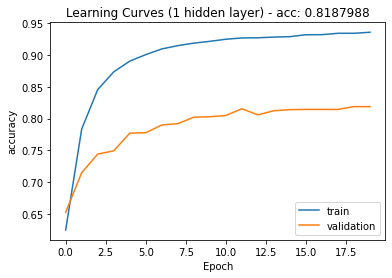

In [16]:
plt.title('Learning Curves (1 hidden layer) - acc: ' + str(history1.history['val_acc'][-1]))
plt.xlabel('Epoch')
plt.ylabel('accuracy')
plt.plot(history1.history['acc'], label='train')
plt.plot(history1.history['val_acc'], label='validation')
plt.legend()
plt.show()

### Improvement by taking a two-hidden layer neural network

We have seen that a one-hidden layer neural network is not precise enough. Therefore, we define a second model with two hidden layers.

<img src="Images/NeuralNetwork2.png" width="480"/>

In [17]:
model2 = tf.keras.models.Sequential([
    tf.keras.layers.Dense(64, activation='sigmoid'),  # 64: number of hidden neurons (1st layer)
    tf.keras.layers.Dense(64, activation='sigmoid'),  # 32: number of hidden neurons (2nd layer)
    tf.keras.layers.Dense(6, activation='sigmoid')    # 6: 6 classes to predict

])
# compile the model
model2.compile(optimizer='Adam',
              loss=loss_fn,
              metrics=['accuracy'])

Let's train the second model for 20 epochs and see if it improves the accuracy.

In [18]:
history2=model2.fit(X_train, y_train,validation_data=(X_test, y_test), epochs=20,verbose=2)
my_loss=model2.evaluate(X_test,  y_test, verbose=False)
print("[loss,accuracy]: ",my_loss)

Train on 7352 samples, validate on 2947 samples
Epoch 1/20
7352/7352 - 1s - loss: 1.5340 - acc: 0.5899 - val_loss: 1.4620 - val_acc: 0.6264
Epoch 2/20
7352/7352 - 1s - loss: 1.3425 - acc: 0.7980 - val_loss: 1.3484 - val_acc: 0.7526
Epoch 3/20
7352/7352 - 1s - loss: 1.2360 - acc: 0.8840 - val_loss: 1.2851 - val_acc: 0.7920
Epoch 4/20
7352/7352 - 1s - loss: 1.1758 - acc: 0.9081 - val_loss: 1.2437 - val_acc: 0.8130
Epoch 5/20
7352/7352 - 1s - loss: 1.1379 - acc: 0.9245 - val_loss: 1.2158 - val_acc: 0.8375
Epoch 6/20
7352/7352 - 1s - loss: 1.1159 - acc: 0.9347 - val_loss: 1.2039 - val_acc: 0.8473
Epoch 7/20
7352/7352 - 1s - loss: 1.1022 - acc: 0.9429 - val_loss: 1.1939 - val_acc: 0.8439
Epoch 8/20
7352/7352 - 1s - loss: 1.0929 - acc: 0.9475 - val_loss: 1.1836 - val_acc: 0.8626
Epoch 9/20
7352/7352 - 1s - loss: 1.0868 - acc: 0.9493 - val_loss: 1.1802 - val_acc: 0.8616
Epoch 10/20
7352/7352 - 1s - loss: 1.0829 - acc: 0.9495 - val_loss: 1.1762 - val_acc: 0.8521
Epoch 11/20
7352/7352 - 1s - lo

Again, we plot the results.

2947/2947 - 0s - loss: 1.1659 - acc: 0.8585


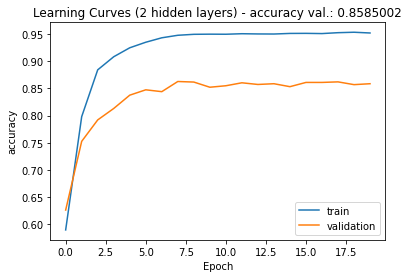

In [19]:
plt.title('Learning Curves (2 hidden layers) - accuracy val.: ' + str(model2.evaluate(X_test,  y_test, verbose=2)[1]))
plt.xlabel('Epoch')
plt.ylabel('accuracy')
plt.plot(history2.history['acc'], label='train')
plt.plot(history2.history['val_acc'], label='validation')
plt.legend()
plt.show()

## 4) Discussion

We have found a neural network by which we obtained an accuracy $\approx 85\%$ (i.e. almost 9 of 10 **new** data are predicted correctly). This seems to be poor but remember that we only had about 5,000 measurements for the train data. If we had 50,000 or even 500,000 measurements this would surely increase the accuracy value.

A crucial point about neural networks is that there are several parameters that can be adjusted to improve the accuracy. In practical applications it is often a big issue to find the optimal parameters and it is ad-hoc unclear by which parameters to start.

Here is a list of such parameters:

- number of hidden layers
- number of neurons in the hidden layer(s)
- activation function
- loss function loss_fn
- optimizer
- dropout (note, that we didn't use a dropout)

Finally, and proably most important point: the results of a neural network cannot be interpreted in a natural way. We do not know what really happens inside the neural network, i.e. it is not replicable how specific patterns of the signal are kept. This is somehow ambivalent because this also means that a neural network does not need any expertise domain knowledge. **However, neural networks are a standard tool for practical applications in machine learning.**

### Summary

Let's summarize the advantages and disadvantages of *neural networks for classification*:

**Pros:**

- accurate results
- short runtime
- no expert domain knowledge of data required

**Cons:**

- results hard to interpret
- unclear how to optimise the method (many parameters that can be adjusted)

## 5) Acknowledgements

We thank UCI repository for providing the UCI HAR dataset.

## 6) Literature

- Davide Anguita, Alessandro Ghio, Luca Oneto, Xavier Parra and Jorge L. Reyes-Ortiz. A Public Domain Dataset for Human Activity Recognition Using Smartphones. 21th European Symposium on Artificial Neural Networks, Computational Intelligence and Machine Learning, ESANN 2013. Bruges, Belgium 24-26 April 2013.
- Fawaz, Hassan Ismail; Forestier, Germain; Weber, Jonathan; Idoumghar, Lhassane; Muller, Pierre-Alain (2019): Deep learning for time series classification: a review. In Data Min Knowl Disc 33 (4), pp. 917–963. DOI: 10.1007/s10618-019-00619-1.